## **Credit Card Behaviour Score Prediction Using Classification and Risk-Based Techniques**

### Project Overview

**Author**: Palak Jagtap  
**Enrollment Number**: 22124028  
**Date**: June 16, 2025  

---

### **Objective**

Develop a binary classification model to predict whether a credit card customer will default on their next month's payment. This enables Bank A to enhance its credit risk management framework by:

- Flagging potential defaulters
- Adjusting credit exposure
- Triggering early warning systems

---

### **Problem Statement**

This notebook uses anonymized behavioral data from over 30,000 credit card customers to build a financially interpretable model for predicting the target variable `next_month_default`  
(1 = Default, 0 = No Default).

The model aims to:

- **Minimize false negatives** (missed defaults), which may result in major loan losses ranging from *10,000 dollars* to *100,000dollars*
- **Minimize false positives** (wrongful denials), which reduce customer approval rates and can cause economic losses from *500dollars* to *5,000dollars*

---

### **Evaluation Metric**

The primary metric used is the **F2 score** (β = 2), which places greater weight on **recall** over precision.  
This aligns with **Bank A's risk-averse strategy**, where missing a potential defaulter is considered more costly than denying a safe applicant.





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###  Install Required Libraries

The following libraries are required for data processing, visualization, model training, and evaluation:

- **pandas, numpy**: Data manipulation and numerical operations  
- **matplotlib, seaborn**: Visualization  
- **scikit-learn**: Machine learning utilities  
- **imbalanced-learn**: Handling class imbalance (e.g., SMOTE)  
- **xgboost, lightgbm**: Gradient boosting classifiers  
- **shap**: Model explainability using SHAP values


In [2]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost lightgbm shap


###  Import Libraries

After installing the required packages, we now import all necessary libraries for:

- **Data handling**: `pandas`, `numpy`
- **Visualization**: `matplotlib`, `seaborn`
- **Modeling**: `LogisticRegression`, `DecisionTreeClassifier`, `XGBClassifier`, `LGBMClassifier`
- **Evaluation metrics**: `accuracy_score`, `f1_score`, `recall_score`, `fbeta_score`, `roc_auc_score`, `roc_curve`
- **Class imbalance handling**: `SMOTE` from `imbalanced-learn`
- **Model explainability**: `SHAP` for feature attribution

A random seed is also set to ensure reproducibility of results.


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, fbeta_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import shap

# Set random seed for reproducibility
np.random.seed(42)

###  Step 1: Load and Explore Datasets

In this step, we load the training and validation datasets from the specified file paths in Google Drive.

- `train_df`: Contains 25,247 records with 27 features
- `validation_df`: Contains 5,016 records with 26 features (excluding the target)

We then explore the structure of the training data:

- **Total Columns**: 27 (including `Customer_ID`, demographic info, payment history, billing amounts, and the target variable `next_month_default`)
- **Missing Values**: Only the `age` column has missing values
- **Data Types**: A mix of integers and floats, suitable for machine learning models

**Class Distribution in Training Set:**

- **No Default (0)**: 80.96%
- **Default (1)**: 19.04%

This confirms a **class imbalance**, which needs to be addressed using techniques like **SMOTE** in later stages.



In [5]:
# Step 1: Load and Explore Datasets
train_df = pd.read_csv('/content/drive/MyDrive/Datasets_final/train_dataset_final1.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Datasets_final/validate_dataset_final.csv')

print("Training Data Shape:", train_df.shape)
print("Validation Data Shape:", validation_df.shape)
print("\nTraining Data Info:")
print(train_df.info())
print("\nClass Distribution in Training Data:")
print(train_df['next_month_default'].value_counts(normalize=True))

Training Data Shape: (25247, 27)
Validation Data Shape: (5016, 26)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3     

###  Data Cleaning & Exploratory Data Analysis (EDA)

This section preprocesses the credit card dataset and conducts exploratory analysis to prepare it for modeling, focusing on identifying default risk drivers and addressing class imbalance.

---

### **1. Categorical Cleaning: Education and Marriage**

- Reclassified `education` values 0, 5, 6 to **4 (Others)**
- Reclassified `marriage` value 0 to **3 (Others)**
- Ensured consistent categorical encoding across training and validation datasets

---

### **2. Age Cleaning**

- Handled invalid age values (≤ 0 or > 100) using **median imputation**
- Imputed missing values in `age` with the median
- Final valid age range: **21–79 years**

---

### **3. Missing Value Handling**

- Only the `age` column had missing values
- Filled missing values using **median imputation**
-  No missing values remain post-preprocessing

---

### **4. Feature Engineering: Payment-to-Bill Ratio**

Created the following features:

- `total_pay_amt`: Sum of payments over 6 months  
- `AVG_Bill_amt`: Mean of billed amounts over 6 months  
- `PAY_TO_BILL_ratio = total_pay_amt / AVG_Bill_amt`
  - Ensured non-negative values
  - Capped values at the 99th percentile to limit the effect of outliers

---

### **5. Visual Exploration**

- **Class Imbalance**: ~81% no-default, ~19% default
- **Distributions**: Visualized `LIMIT_BAL`, `age`, `PAY_TO_BILL_ratio`, etc., by default status
- **Categorical Analysis**: Compared `sex`, `marriage`, `education` across default categories
- **Delinquency Streak**: Created feature based on consecutive delayed payments
- **Payment Trends**: Analyzed monthly `pay_status` and `credit utilization` by default group
- **Repayment Consistency**: Introduced `payment_volatility` as standard deviation of payment amounts
- **Correlation Matrix**: Heatmap illustrated inter-feature relationships

---

### **6. Statistical Summary by Default Class**

| **Metric**             | **No Default (Mean)** | **Default (Mean)** |
|------------------------|------------------------|---------------------|
| `LIMIT_BAL`            | 177,539                | 129,234             |
| `AVG_Bill_amt`         | 45,344                 | 42,996              |
| `PAY_TO_BILL_ratio`    | 2.47                   | 1.80                |
| `delinquency_streak`   | 0.48                   | 1.90                |
| `payment_volatility`   | 6,402                  | 3,764               |
| `total_pay_amt`        | 34,911                 | 20,134              |

---

###  **Final Step**

Saved preprocessed datasets:
- `train_preprocessed.csv`
- `validation_preprocessed.csv`

These datasets are now ready for model training.


Education Value Counts (Training):
education
2    11717
1     8988
3     4115
4      427
Name: count, dtype: int64

Education Value Counts (Validation):
education
2    2374
1    1796
3     760
4      86
Name: count, dtype: int64

Marriage Value Counts (Training):
marriage
2    13441
1    11480
3      326
Name: count, dtype: int64

Marriage Value Counts (Validation):
marriage
2    2702
1    2262
3      52
Name: count, dtype: int64

Education Value Counts After Reclassification (Training):
education
2    11717
1     8988
3     4115
4      427
Name: count, dtype: int64

Marriage Value Counts After Reclassification (Training):
marriage
2    13441
1    11480
3      326
Name: count, dtype: int64

Age Value Counts (Training):
age
21.0      58
22.0     468
23.0     774
24.0     948
25.0     976
26.0    1049
27.0    1258
28.0    1188
29.0    1353
30.0    1162
31.0    1027
32.0     946
33.0     976
34.0    1105
35.0     951
36.0     944
37.0     876
38.0     800
39.0     806
40.0     741
41.0   

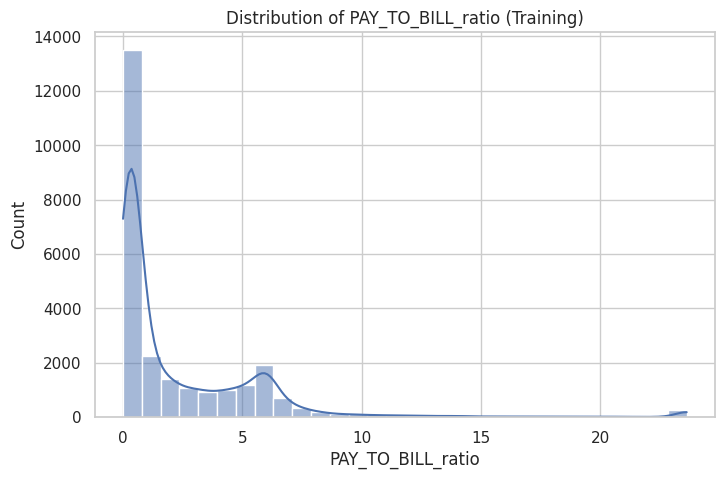


Number of negative values in AVG_Bill_amt: 0
Number of negative values in total_pay_amt: 0


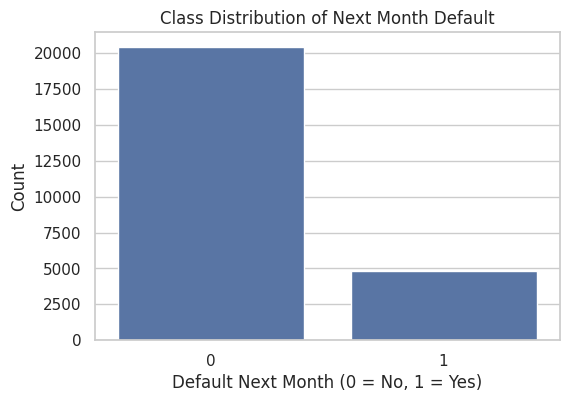

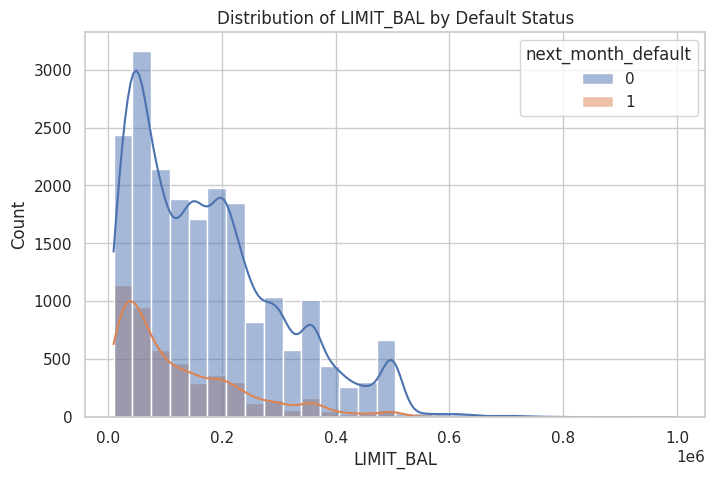

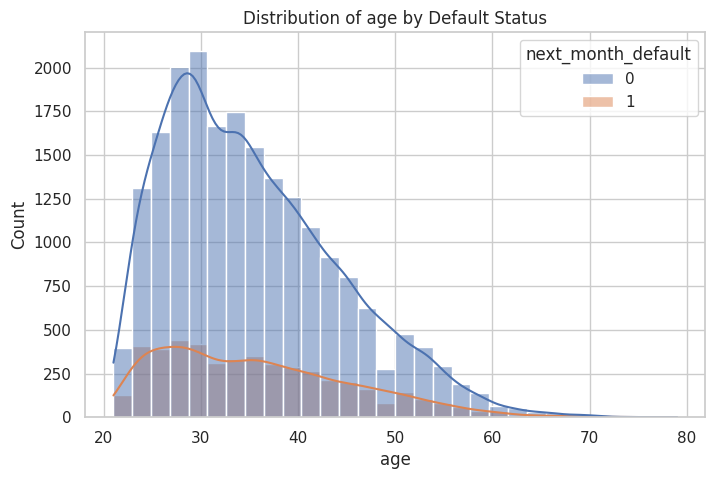

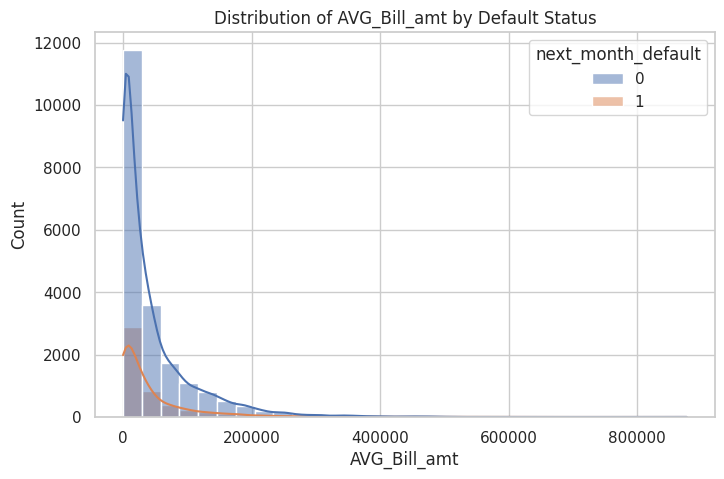

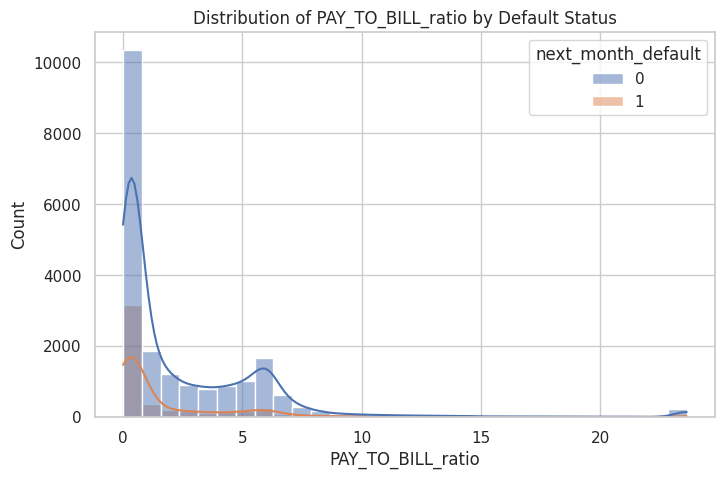

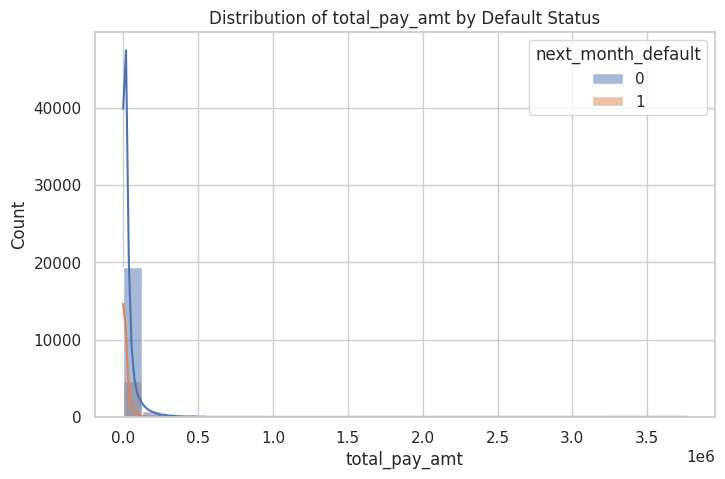

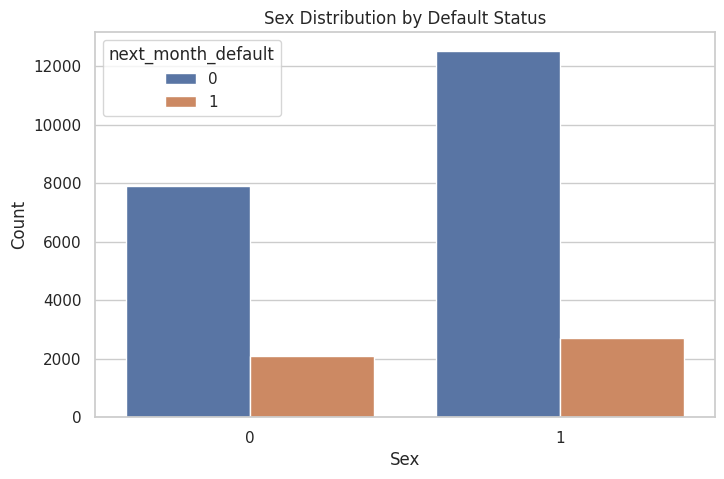

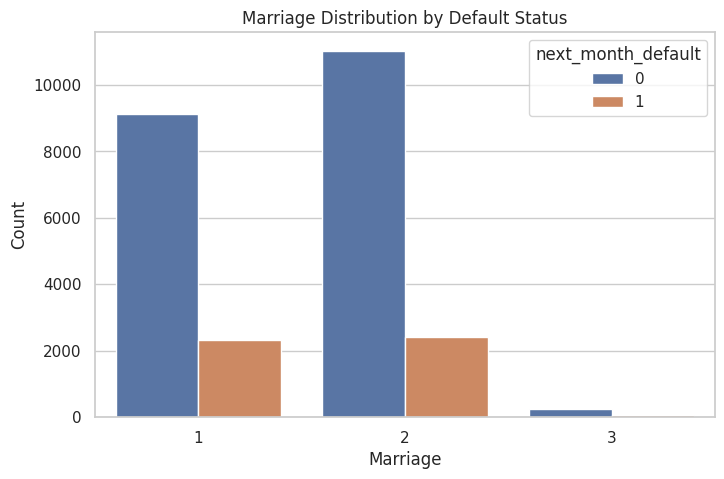

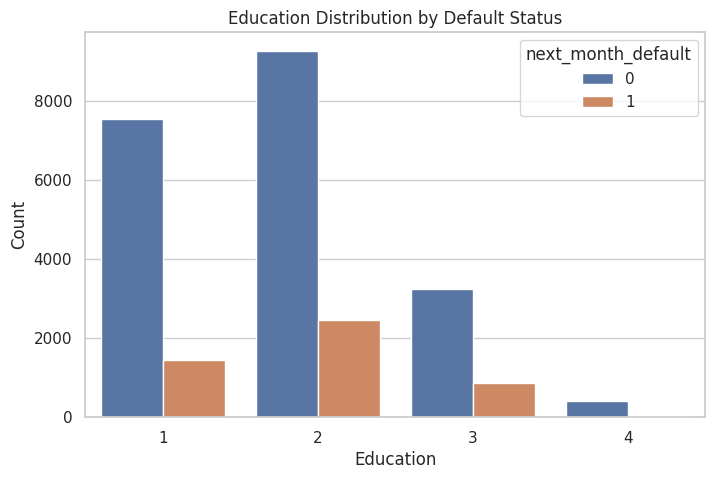

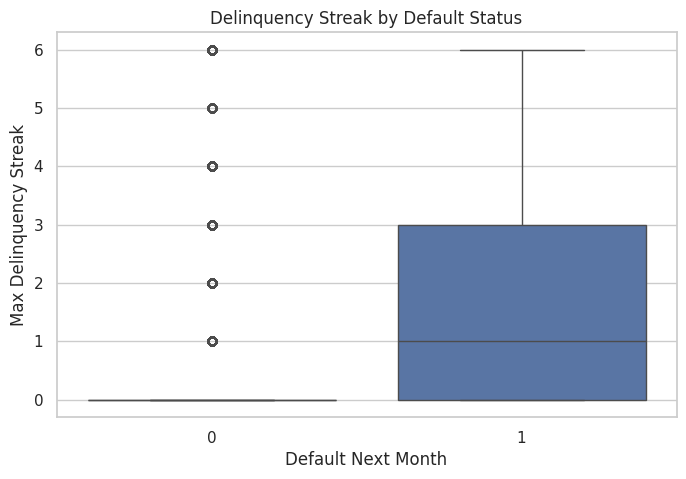

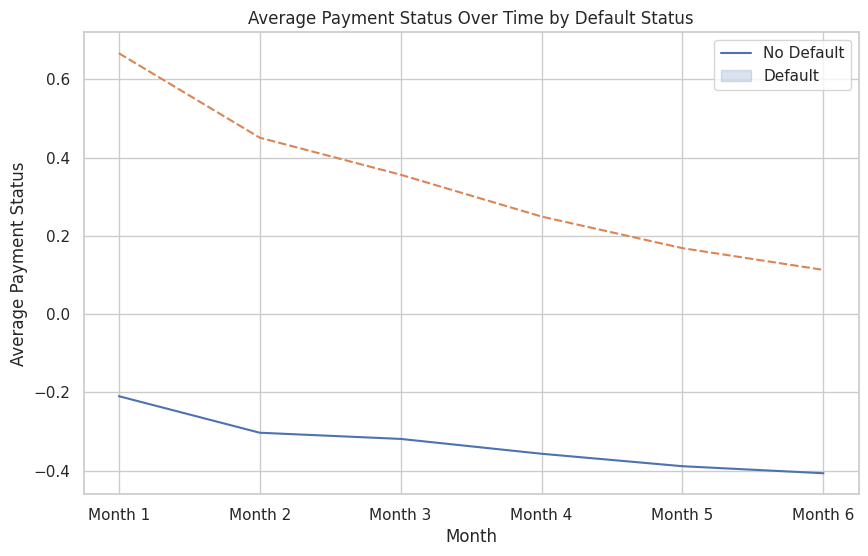

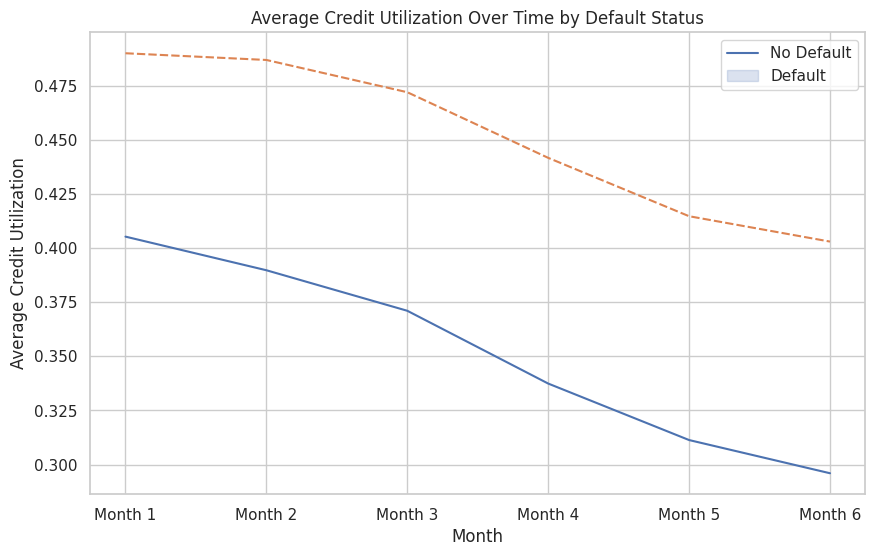

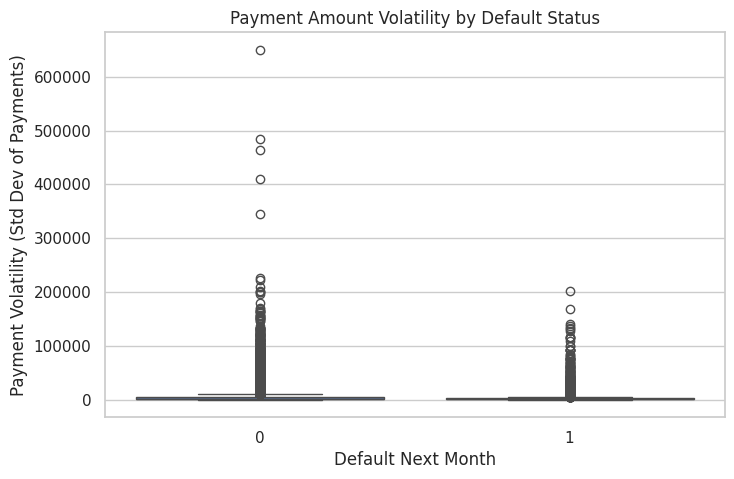

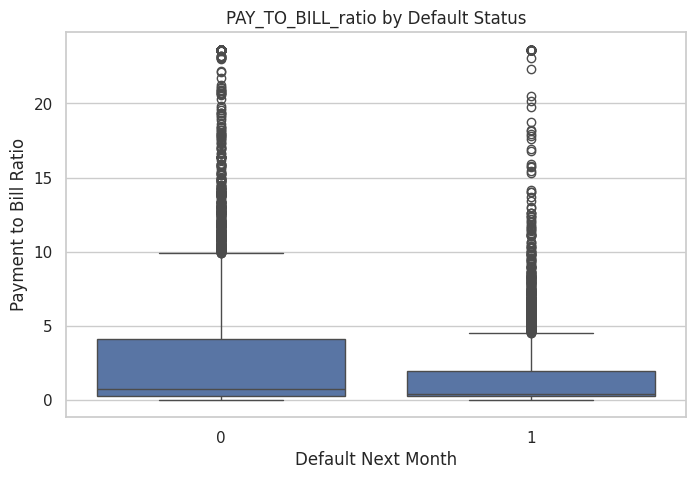

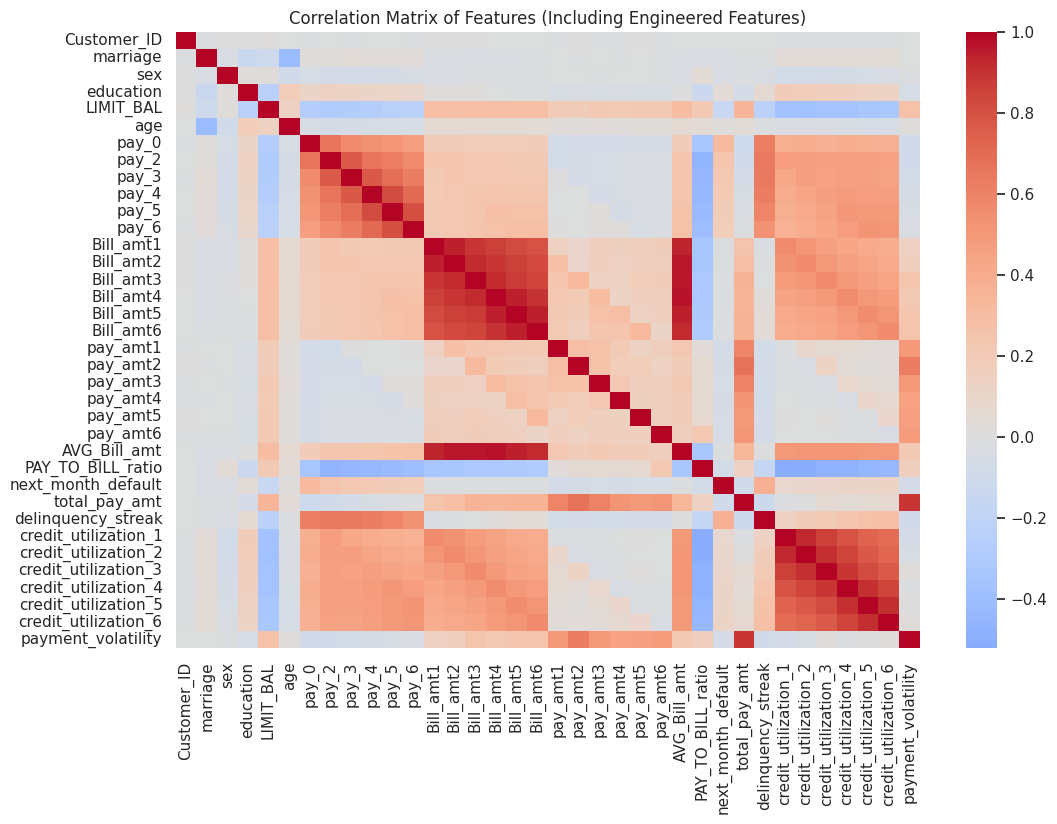


Summary Statistics by Default Status:
                    LIMIT_BAL           AVG_Bill_amt            \
                         mean    median         mean    median   
next_month_default                                               
0                   177539.24  150000.0     45343.89  21501.17   
1                   129234.45   90000.0     42996.47  19671.85   

                   PAY_TO_BILL_ratio        delinquency_streak         \
                                mean median               mean median   
next_month_default                                                      
0                               2.47   0.75               0.48    0.0   
1                               1.80   0.38               1.90    1.0   

                   payment_volatility          total_pay_amt           
                                 mean   median          mean   median  
next_month_default                                                     
0                             6402.31  1533.43  

In [7]:

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


# 1. Handle Discrepancies in Education and Marriage
print("Education Value Counts (Training):")
print(train_df['education'].value_counts())
print("\nEducation Value Counts (Validation):")
print(validation_df['education'].value_counts())

print("\nMarriage Value Counts (Training):")
print(train_df['marriage'].value_counts())
print("\nMarriage Value Counts (Validation):")
print(validation_df['marriage'].value_counts())

train_df['education'] = train_df['education'].replace([0, 5, 6], 4)
validation_df['education'] = validation_df['education'].replace([0, 5, 6], 4)
train_df['marriage'] = train_df['marriage'].replace(0, 3)
validation_df['marriage'] = validation_df['marriage'].replace(0, 3)

print("\nEducation Value Counts After Reclassification (Training):")
print(train_df['education'].value_counts())
print("\nMarriage Value Counts After Reclassification (Training):")
print(train_df['marriage'].value_counts())

# 2. Handle Age Discrepancies
print("\nAge Value Counts (Training):")
print(train_df['age'].value_counts().sort_index())
print("\nAge Summary Statistics (Training):")
print(train_df['age'].describe())

invalid_ages = (train_df['age'] <= 0) | (train_df['age'] > 100)
print(f"\nNumber of Invalid Ages (<=0 or >100) in Training: {invalid_ages.sum()}")

valid_ages = train_df.loc[~invalid_ages, 'age']
age_median = valid_ages.median()
train_df.loc[invalid_ages, 'age'] = age_median

invalid_ages_val = (validation_df['age'] <= 0) | (validation_df['age'] > 100)
if invalid_ages_val.sum() > 0:
    validation_df.loc[invalid_ages_val, 'age'] = age_median

print("\nAge Value Counts After Imputation (Training):")
print(train_df['age'].value_counts().sort_index())

# 3. Handle Missing Values
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())
print("\nMissing Values in Validation Data:")
print(validation_df.isnull().sum())

if train_df['age'].isnull().any():
    train_df['age'] = train_df['age'].fillna(age_median)
if validation_df['age'].isnull().any():
    validation_df['age'] = validation_df['age'].fillna(age_median)

print("\nMissing Values After Imputation (Training):")
print(train_df.isnull().sum())

# 4. Calculate PAY_TO_BILL_ratio
pay_cols = [f'pay_amt{i}' for i in range(1, 7)]
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]

# Verify negative values
print("\nSummary Statistics for Payment Amounts (Training):")
print(train_df[pay_cols].describe())
for col in pay_cols:
    neg_count = (train_df[col] < 0).sum()
    print(f"Number of negative values in {col}: {neg_count}")

print("\nSummary Statistics for Bill Amounts (Training):")
print(train_df[bill_cols].describe())
for col in bill_cols:
    neg_count = (train_df[col] < 0).sum()
    print(f"Number of negative values in {col}: {neg_count}")

train_df['total_pay_amt'] = train_df[pay_cols].sum(axis=1)
train_df['AVG_Bill_amt'] = train_df[bill_cols].mean(axis=1)
validation_df['total_pay_amt'] = validation_df[pay_cols].sum(axis=1)
validation_df['AVG_Bill_amt'] = validation_df[bill_cols].mean(axis=1)

# Updated safe_ratio to ensure non-negative ratios
def safe_ratio(pay, bill):
    if pd.isna(bill) or bill <= 0:
        return 0.0
    return pay / bill

train_df['PAY_TO_BILL_ratio'] = train_df.apply(lambda row: safe_ratio(row['total_pay_amt'], row['AVG_Bill_amt']), axis=1)
validation_df['PAY_TO_BILL_ratio'] = validation_df.apply(lambda row: safe_ratio(row['total_pay_amt'], row['AVG_Bill_amt']), axis=1)

# Clip PAY_TO_BILL_ratio to ensure non-negative and cap extreme values
ratio_99 = train_df.loc[train_df['PAY_TO_BILL_ratio'] > 0, 'PAY_TO_BILL_ratio'].quantile(0.99)
train_df['PAY_TO_BILL_ratio'] = train_df['PAY_TO_BILL_ratio'].clip(lower=0, upper=ratio_99)
validation_df['PAY_TO_BILL_ratio'] = validation_df['PAY_TO_BILL_ratio'].clip(lower=0, upper=ratio_99)

print("\nPAY_TO_BILL_ratio Summary Statistics (Training):")
print(train_df['PAY_TO_BILL_ratio'].describe())

# Visualize PAY_TO_BILL_ratio
plt.figure(figsize=(8, 5))
sns.histplot(train_df['PAY_TO_BILL_ratio'], bins=30, kde=True)
plt.title('Distribution of PAY_TO_BILL_ratio (Training)')
plt.xlabel('PAY_TO_BILL_ratio')
plt.ylabel('Count')
plt.show()

# Verify negative values in AVG_Bill_amt and total_pay_amt
print("\nNumber of negative values in AVG_Bill_amt:", (train_df['AVG_Bill_amt'] < 0).sum())
print("Number of negative values in total_pay_amt:", (train_df['total_pay_amt'] < 0).sum())

# 5. Visualize Class Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='next_month_default', data=train_df)
plt.title('Class Distribution of Next Month Default')
plt.xlabel('Default Next Month (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# 6. Distribution of Numerical Features
for col in ['LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'total_pay_amt']:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=train_df, x=col, hue='next_month_default', bins=30, kde=True)
    plt.title(f'Distribution of {col} by Default Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# 7. Categorical Variables Analysis
categorical_cols = ['sex', 'marriage', 'education']
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, hue='next_month_default', data=train_df)
    plt.title(f'{col.capitalize()} Distribution by Default Status')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.show()

# 8. Payment Delays: Delinquency Streaks
def calculate_delinquency_streak(row):
    pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    streak = 0
    max_streak = 0
    for col in pay_cols:
        if row[col] >= 1:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

train_df['delinquency_streak'] = train_df.apply(calculate_delinquency_streak, axis=1)
plt.figure(figsize=(8, 5))
sns.boxplot(x='next_month_default', y='delinquency_streak', data=train_df)
plt.title('Delinquency Streak by Default Status')
plt.xlabel('Default Next Month')
plt.ylabel('Max Delinquency Streak')
plt.show()

# 9. Payment Status Over Time
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
pay_trends = train_df.groupby('next_month_default')[pay_cols].mean().T
pay_trends.index = ['Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5', 'Month 6']
plt.figure(figsize=(10, 6))
sns.lineplot(data=pay_trends)
plt.title('Average Payment Status Over Time by Default Status')
plt.xlabel('Month')
plt.ylabel('Average Payment Status')
plt.legend(['No Default', 'Default'])
plt.show()

# 10. Credit Utilization Over Time
for i in range(1, 7):
    train_df[f'credit_utilization_{i}'] = train_df[f'Bill_amt{i}'] / train_df['LIMIT_BAL']
utilization_cols = [f'credit_utilization_{i}' for i in range(1, 7)]
utilization_trends = train_df.groupby('next_month_default')[utilization_cols].mean().T
utilization_trends.index = ['Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5', 'Month 6']
plt.figure(figsize=(10, 6))
sns.lineplot(data=utilization_trends)
plt.title('Average Credit Utilization Over Time by Default Status')
plt.xlabel('Month')
plt.ylabel('Average Credit Utilization')
plt.legend(['No Default', 'Default'])
plt.show()

# 11. Repayment Consistency: Payment Amount Variability
train_df['payment_volatility'] = train_df[[f'pay_amt{i}' for i in range(1, 7)]].std(axis=1)
plt.figure(figsize=(8, 5))
sns.boxplot(x='next_month_default', y='payment_volatility', data=train_df)
plt.title('Payment Amount Volatility by Default Status')
plt.xlabel('Default Next Month')
plt.ylabel('Payment Volatility (Std Dev of Payments)')
plt.show()

# 12. PAY_TO_BILL_ratio Distribution
plt.figure(figsize=(8, 5))
sns.boxplot(x='next_month_default', y='PAY_TO_BILL_ratio', data=train_df)
plt.title('PAY_TO_BILL_ratio by Default Status')
plt.xlabel('Default Next Month')
plt.ylabel('Payment to Bill Ratio')
plt.show()

# 13. Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features (Including Engineered Features)')
plt.show()

# 14. Summary Statistics by Default Status
default_group = train_df.groupby('next_month_default').agg({
    'LIMIT_BAL': ['mean', 'median'],
    'AVG_Bill_amt': ['mean', 'median'],
    'PAY_TO_BILL_ratio': ['mean', 'median'],
    'delinquency_streak': ['mean', 'median'],
    'payment_volatility': ['mean', 'median'],
    'total_pay_amt': ['mean', 'median']
}).round(2)
print("\nSummary Statistics by Default Status:")
print(default_group)

# Save preprocessed datasets
train_df.to_csv('/content/drive/MyDrive/Datasets_final/train_preprocessed.csv', index=False)
validation_df.to_csv('/content/drive/MyDrive/Datasets_final/validation_preprocessed.csv', index=False)
print("\nPreprocessed datasets saved as 'train_preprocessed.csv' and 'validation_preprocessed.csv'")

---

### 🧪 Step 3: Feature Engineering & Final Dataset Preparation

This section performs domain-specific feature engineering, encoding, scaling, and class balancing to prepare the dataset for training and evaluation.

---

### **1. Advanced Feature Engineering**

Created several new features to enhance predictive power:

- **Delinquency Streak**: Maximum consecutive months with delayed payments (`pay ≥ 1`)
- **Credit Utilization**: Ratio of `Bill_amt{i} / LIMIT_BAL` for each month (1–6)
- **Payment Volatility**: Standard deviation of payment amounts across 6 months
- **Average Payment Status**: Mean of payment status values (`pay_0` to `pay_6`)
- **Total Overdue Months**: Count of months with overdue payments (`pay ≥ 1`)

These features were generated for both training and validation datasets.

---

### **2. Train-Test Split**

Performed before preprocessing to avoid data leakage:

- Split the training dataset into:
  - **80%** for training
  - **20%** for internal validation
- Stratified on the target variable to preserve class distribution

---

### **3. One-Hot Encoding**

- Applied one-hot encoding to categorical variables:
  - `sex`, `marriage`, and `education`
- Dropped the first category in each to prevent multicollinearity
- Ensured feature alignment across:
  - Training data
  - Internal validation set
  - External validation set

---

### **4. Feature Standardization**

- Standardized all numerical features using `StandardScaler`
- Ensured consistent scale across features like:
  - `LIMIT_BAL`, `age`, `Bill_amt{i}`, `pay_amt{i}`, etc.
  - Engineered features: `credit_utilization`, `payment_volatility`, etc.

---

### **5. Addressing Class Imbalance (SMOTE)**

- Applied **SMOTE (Synthetic Minority Over-sampling Technique)** to the training data
- Balanced class distribution:
  - `Default (1)`: 50%
  - `No Default (0)`: 50%

This significantly improves the model’s ability to detect defaulters, reducing false negatives.

---

### **6. Final Output**

Saved the following datasets after preprocessing and alignment:

- `train_features.csv` — SMOTE-balanced training features  
- `train_labels.csv` — Corresponding training labels  
- `internal_validation_features.csv` — Internal validation features  
- `internal_validation_labels.csv` — Internal validation labels  
- `validation_features.csv` — Final external validation features  
- `validation_customer_id.csv` — Stored customer IDs for submission (if available)

These datasets are now fully prepared for model training, evaluation, and external submission.

---


In [28]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load preprocessed datasets from EDA
train_df = pd.read_csv('/content/drive/MyDrive/Datasets_final/train_preprocessed.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Datasets_final/validation_preprocessed.csv')

# Store Customer_ID for submission
validation_customer_id = validation_df['Customer_ID'] if 'Customer_ID' in validation_df.columns else None
print("Initial validation_df columns:", validation_df.columns.tolist())

# 1. Feature Engineering (deterministic, done before split)
def calculate_delinquency_streak(row):
    pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    streak = 0
    max_streak = 0
    for col in pay_cols:
        if row[col] >= 1:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

train_df['delinquency_streak'] = train_df.apply(calculate_delinquency_streak, axis=1)
validation_df['delinquency_streak'] = validation_df.apply(calculate_delinquency_streak, axis=1)

for i in range(1, 7):
    train_df[f'credit_utilization_{i}'] = train_df[f'Bill_amt{i}'] / train_df['LIMIT_BAL']
    validation_df[f'credit_utilization_{i}'] = validation_df[f'Bill_amt{i}'] / validation_df['LIMIT_BAL']

train_df['payment_volatility'] = train_df[[f'pay_amt{i}' for i in range(1, 7)]].std(axis=1)
validation_df['payment_volatility'] = validation_df[[f'pay_amt{i}' for i in range(1, 7)]].std(axis=1)

train_df['avg_pay_status'] = train_df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].mean(axis=1)
train_df['total_overdue_months'] = train_df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].apply(lambda x: (x >= 1).sum(), axis=1)
validation_df['avg_pay_status'] = validation_df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].mean(axis=1)
validation_df['total_overdue_months'] = validation_df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].apply(lambda x: (x >= 1).sum(), axis=1)

# 2. Train-Test Split (before preprocessing to avoid leakage)
X = train_df.drop(['Customer_ID', 'next_month_default'], axis=1)
y = train_df['next_month_default']
X_train, X_val_internal, y_train, y_val_internal = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Combine X_train and y_train back into a DataFrame for preprocessing
train_sub_df = pd.concat([X_train, y_train], axis=1)
val_internal_df = pd.concat([X_val_internal, y_val_internal], axis=1)

# 3. One-Hot Encoding for categorical variables
categorical_cols = ['sex', 'marriage', 'education']
train_sub_df = pd.get_dummies(train_sub_df, columns=categorical_cols, drop_first=True)
val_internal_df = pd.get_dummies(val_internal_df, columns=categorical_cols, drop_first=True)
validation_df = pd.get_dummies(validation_df, columns=categorical_cols, drop_first=True)

# Align columns after encoding
missing_cols_internal = set(train_sub_df.columns) - set(val_internal_df.columns) - {'next_month_default'}
for col in missing_cols_internal:
    val_internal_df[col] = 0
val_internal_df = val_internal_df[train_sub_df.columns]

missing_cols_val = set(train_sub_df.columns) - set(validation_df.columns) - {'next_month_default'}
for col in missing_cols_val:
    validation_df[col] = 0
validation_df = validation_df[train_sub_df.columns.drop('next_month_default')]
print("validation_df columns after alignment:", validation_df.columns.tolist())

# 4. Standardize Numerical Features
numerical_cols = [
    'LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'total_pay_amt',
    'delinquency_streak', 'avg_pay_status', 'total_overdue_months', 'payment_volatility'
] + [f'credit_utilization_{i}' for i in range(1, 7)] + \
  [f'Bill_amt{i}' for i in range(1, 7)] + \
  [f'pay_amt{i}' for i in range(1, 7)]

scaler = StandardScaler()
train_sub_df[numerical_cols] = scaler.fit_transform(train_sub_df[numerical_cols])
val_internal_df[numerical_cols] = scaler.transform(val_internal_df[numerical_cols])
validation_df[numerical_cols] = scaler.transform(validation_df[numerical_cols])

# 5. Handle Class Imbalance with SMOTE
X_train_sub = train_sub_df.drop(['next_month_default'], axis=1)
y_train_sub = train_sub_df['next_month_default']
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_sub, y_train_sub)

# Verify class distribution after SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))

# Prepare validation data
X_val_internal = val_internal_df.drop(['next_month_default'], axis=1)
y_val_internal = val_internal_df['next_month_default']
X_val = validation_df.copy()  # Features are aligned, no need to drop Customer_ID

# Save processed datasets
X_train_smote.to_csv('/content/drive/MyDrive/Datasets_final/train_features.csv', index=False)
y_train_smote.to_csv('/content/drive/MyDrive/Datasets_final/train_labels.csv', index=False)
X_val_internal.to_csv('/content/drive/MyDrive/Datasets_final/internal_validation_features.csv', index=False)
y_val_internal.to_csv('/content/drive/MyDrive/Datasets_final/internal_validation_labels.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/Datasets_final/validation_features.csv', index=False)
if validation_customer_id is not None:
    validation_customer_id.to_csv('/content/drive/MyDrive/Datasets_final/validation_customer_id.csv', index=False)
print("\nProcessed datasets saved as 'train_features.csv', 'train_labels.csv', 'internal_validation_features.csv', 'internal_validation_labels.csv', 'validation_features.csv', and 'validation_customer_id.csv' ")

Initial validation_df columns: ['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'total_pay_amt']
validation_df columns after alignment: ['LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'total_pay_amt', 'delinquency_streak', 'credit_utilization_1', 'credit_utilization_2', 'credit_utilization_3', 'credit_utilization_4', 'credit_utilization_5', 'credit_utilization_6', 'payment_volatility', 'avg_pay_status', 'total_overdue_months', 'sex_1', 'marriage_2', 'marriage_3', 'education_2', 'education_3', 'education_4']

Class Distri

---

###  Step 4: Model Selection and Cross-Validation

This section evaluates multiple classification models to identify the most effective one for predicting credit card defaults. The models are assessed using:

- **Internal validation performance** (on hold-out validation set)
- **5-fold cross-validation (CV)**

The primary metric used is the **F2 Score**, which emphasizes recall — important for **minimizing missed defaulters**.

---

### ** Models Evaluated**

- Logistic Regression  
- Decision Tree Classifier  
- XGBoost Classifier  
- LightGBM Classifier  

**Evaluation Metrics**:
- **F2 Score (β = 2)** – Emphasizes recall
- **Precision**
- **Recall**
- **AUC-ROC**

---

###  Internal Validation Results (Default Threshold)

| Model                | F2 Score | Precision | Recall | AUC-ROC |
|----------------------|----------|-----------|--------|---------|
| **Logistic Regression**  | **0.5487**   | 0.4073    | 0.6008 | 0.7473  |
| Decision Tree        | 0.4214   | 0.3184    | 0.4584 | 0.6138  |
| XGBoost              | 0.4254   | 0.5227    | 0.4064 | 0.7427  |
| LightGBM             | 0.4737   | 0.5652    | 0.4553 | 0.7708  |

**Best on Internal Validation**: **Logistic Regression** with **F2 Score = 0.5487**

---

###  5-Fold Cross-Validation Results

| Model                | F2 Score | Precision | Recall | AUC-ROC |
|----------------------|----------|-----------|--------|---------|
| Logistic Regression  | 0.6636   | 0.7600    | 0.6433 | 0.7865  |
| Decision Tree        | 0.7877   | 0.7697    | 0.7943 | 0.7792  |
| **XGBoost**          | **0.8065** | 0.8911    | 0.8050 | **0.9336**  |
| LightGBM             | 0.7918   | **0.9041**| 0.7889 | 0.9302  |

 **Best on Cross-Validation**: **XGBoost**, with the highest **F2 Score = 0.8065** and strong AUC-ROC.

---

###  Final Model Selection: Logistic Regression (Internal Validation Focus)

- Despite XGBoost's dominance in cross-validation, **Logistic Regression** showed **superior performance on the internal validation set** (higher F2 score).
- To ensure **generalization**, both internal validation and cross-validation were considered.
-  **Final Model Chosen**: **Logistic Regression**  
- Saved as: `best_model.pkl`

---

###  Next Steps

- Use the selected model for external evaluation.
- Perform explainability analysis using **SHAP values** to interpret model predictions.

---


In [20]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

# Load processed datasets from feature engineering
X_train = pd.read_csv('/content/drive/MyDrive/Datasets_final/train_features.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Datasets_final/train_labels.csv').values.ravel()
X_val_internal = pd.read_csv('/content/drive/MyDrive/Datasets_final/internal_validation_features.csv')
y_val_internal = pd.read_csv('/content/drive/MyDrive/Datasets_final/internal_validation_labels.csv').values.ravel()

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Evaluate models on internal validation set (using default threshold = 0.5)
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val_internal)
    y_pred_proba = model.predict_proba(X_val_internal)[:, 1]

    results[name] = {
        'F2 Score': fbeta_score(y_val_internal, y_pred, beta=2),
        'Precision': precision_score(y_val_internal, y_pred),
        'Recall': recall_score(y_val_internal, y_pred),
        'AUC-ROC': roc_auc_score(y_val_internal, y_pred_proba)
    }

    print(f"{name} Internal Validation Results:")
    print(f"F2 Score: {results[name]['F2 Score']:.4f}")
    print(f"Precision: {results[name]['Precision']:.4f}")
    print(f"Recall: {results[name]['Recall']:.4f}")
    print(f"AUC-ROC: {results[name]['AUC-ROC']:.4f}")

# Display comparison table
results_df = pd.DataFrame(results).T
print("\nModel Comparison (Internal Validation, Default Threshold):")
print(results_df)

# Identify and save best model (based on F2 Score)
best_model_name = results_df['F2 Score'].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} (F2 Score: {results_df.loc[best_model_name, 'F2 Score']:.4f})")
joblib.dump(best_model, '/content/drive/MyDrive/Datasets_final/best_model.pkl')
print(f"Best model ({best_model_name}) saved as 'best_model.pkl'")

# Optional: Cross-validation on training data for robustness
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring = {
    'f2_score': f2_scorer,
    'precision': 'precision',
    'recall': 'recall',
    'auc_roc': 'roc_auc'
}
cv_results = {}
for name, model in models.items():
    print(f"\nPerforming 5-fold CV for {name}...")
    cv_scores = cross_validate(
        model, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    cv_results[name] = {
        'F2 Score': cv_scores['test_f2_score'].mean(),
        'Precision': cv_scores['test_precision'].mean(),
        'Recall': cv_scores['test_recall'].mean(),
        'AUC-ROC': cv_scores['test_auc_roc'].mean()
    }
    print(f"{name} CV Results:")
    print(f"F2 Score: {cv_results[name]['F2 Score']:.4f}")
    print(f"Precision: {cv_results[name]['Precision']:.4f}")
    print(f"Recall: {cv_results[name]['Recall']:.4f}")
    print(f"AUC-ROC: {cv_results[name]['AUC-ROC']:.4f}")

# Display CV comparison table
cv_results_df = pd.DataFrame(cv_results).T
print("\nModel Comparison (5-fold Cross-Validation):")
print(cv_results_df)



Evaluating Logistic Regression...
Logistic Regression Internal Validation Results:
F2 Score: 0.5487
Precision: 0.4073
Recall: 0.6008
AUC-ROC: 0.7473

Evaluating Decision Tree...
Decision Tree Internal Validation Results:
F2 Score: 0.4214
Precision: 0.3184
Recall: 0.4584
AUC-ROC: 0.6138

Evaluating XGBoost...
XGBoost Internal Validation Results:
F2 Score: 0.4254
Precision: 0.5227
Recall: 0.4064
AUC-ROC: 0.7427

Evaluating LightGBM...
LightGBM Internal Validation Results:
F2 Score: 0.4737
Precision: 0.5652
Recall: 0.4553
AUC-ROC: 0.7708

Model Comparison (Internal Validation, Default Threshold):
                     F2 Score  Precision    Recall   AUC-ROC
Logistic Regression  0.548699   0.407329  0.600832  0.747270
Decision Tree        0.421364   0.318412  0.458420  0.613750
XGBoost              0.425370   0.522727  0.406445  0.742707
LightGBM             0.473718   0.565161  0.455301  0.770840

Best Model: Logistic Regression (F2 Score: 0.5487)
Best model (Logistic Regression) saved as

---

###  Step 5: Threshold Tuning, Final Prediction & Submission

This section tunes the classification threshold of each model to maximize the **F2 Score** on the internal validation set. The best-performing model is then selected and saved for deployment.

---

### **1. Load Model & Data**

- Loaded preprocessed datasets:
  - `train_features.csv`
  - `train_labels.csv`
  - `internal_validation_features.csv`
  - `internal_validation_labels.csv`
- Evaluated the following models:
  - **Logistic Regression**
  - **Decision Tree**
  - **XGBoost**
  - **LightGBM**

---

### **2. Threshold Tuning & Evaluation**

- For each model, calculated **Precision**, **Recall**, and **F2 Scores** across multiple classification thresholds
- Chose the **optimal threshold** that maximized the F2 Score
- Computed evaluation metrics at that threshold

####  Model Performance Summary (After Tuning)

| Model                | F2 Score | Precision | Recall | AUC-ROC | Optimal Threshold |
|----------------------|----------|-----------|--------|---------|-------------------|
| Logistic Regression  | 0.5766   | 0.2618    | 0.8243 | 0.7473  | 0.3322            |
| Decision Tree        | 0.5406   | 0.1905    | 1.0000 | 0.6138  | 0.0000            |
| XGBoost              | 0.5808   | 0.2612    | 0.8368 | 0.7427  | 0.1109            |
| **LightGBM**         | **0.6039** | **0.2716**  | **0.8701** | **0.7708**  | **0.1586**            |

 **Best Model Selected**: **LightGBM**  
 **Optimal Threshold**: `0.1586`

---

### **3. Final Outputs**

- Saved the best model and threshold using `joblib`:
  - `best_model.pkl`
  - `best_threshold.pkl`
- These files will be used for:
  - Final evaluation on the external validation set
  - Generating predictions and submission files
  - SHAP-based explainability

---

###  Next Steps

- Load the saved model and threshold
- Generate a formatted CSV submission


---


In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score, precision_recall_curve
import joblib

# Load data
X_train = pd.read_csv('/content/drive/MyDrive/Datasets_final/train_features.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Datasets_final/train_labels.csv').values.ravel()
X_val_internal = pd.read_csv('/content/drive/MyDrive/Datasets_final/internal_validation_features.csv')
y_val_internal = pd.read_csv('/content/drive/MyDrive/Datasets_final/internal_validation_labels.csv').values.ravel()

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Store results
results = {}
optimal_thresholds = {}

# Evaluate each model
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val_internal)[:, 1]

    # Threshold tuning with F2
    precisions, recalls, thresholds = precision_recall_curve(y_val_internal, y_pred_proba)
    f2_scores = [(5 * p * r) / (4 * p + r + 1e-10) for p, r in zip(precisions, recalls)]
    optimal_idx = np.argmax(f2_scores)

    # Handle edge case when threshold list is shorter than precision/recall
    if optimal_idx >= len(thresholds):
        optimal_idx = len(thresholds) - 1

    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds[name] = optimal_threshold
    y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)

    f2 = fbeta_score(y_val_internal, y_pred_opt, beta=2)
    precision = precision_score(y_val_internal, y_pred_opt)
    recall = recall_score(y_val_internal, y_pred_opt)
    auc = roc_auc_score(y_val_internal, y_pred_proba)

    results[name] = {
        'F2 Score (Tuned)': f2,
        'Precision (Tuned)': precision,
        'Recall (Tuned)': recall,
        'AUC-ROC': auc,
        'Optimal Threshold': optimal_threshold
    }

    print(f"{name} Tuned Threshold: {optimal_threshold:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Comparison After Threshold Tuning:")
print(results_df)

# Identify best model
best_model_name = results_df['F2 Score (Tuned)'].idxmax()
best_model = models[best_model_name]
best_threshold = optimal_thresholds[best_model_name]

# Save best model and threshold
joblib.dump(best_model, '/content/drive/MyDrive/Datasets_final/best_model.pkl')
joblib.dump(best_threshold, '/content/drive/MyDrive/Datasets_final/best_threshold.pkl')

print(f"\n✅ Best Model: {best_model_name} (F2 Score: {results_df.loc[best_model_name, 'F2 Score (Tuned)']:.4f})")
print(f"Model and threshold saved as 'best_model.pkl' and 'best_threshold.pkl'")



Evaluating Logistic Regression...
Logistic Regression Tuned Threshold: 0.3322
F2 Score: 0.5766
Precision: 0.2618
Recall: 0.8243
AUC-ROC: 0.7473

Evaluating Decision Tree...
Decision Tree Tuned Threshold: 0.0000
F2 Score: 0.5406
Precision: 0.1905
Recall: 1.0000
AUC-ROC: 0.6138

Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:05:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Tuned Threshold: 0.1109
F2 Score: 0.5808
Precision: 0.2612
Recall: 0.8368
AUC-ROC: 0.7427

Evaluating LightGBM...
LightGBM Tuned Threshold: 0.1586
F2 Score: 0.6039
Precision: 0.2716
Recall: 0.8701
AUC-ROC: 0.7708

Model Comparison After Threshold Tuning:
                     F2 Score (Tuned)  Precision (Tuned)  Recall (Tuned)  \
Logistic Regression          0.576560           0.261803        0.824324   
Decision Tree                0.540571           0.190495        1.000000   
XGBoost                      0.580808           0.261194        0.836798   
LightGBM                     0.603896           0.271577        0.870062   

                      AUC-ROC  Optimal Threshold  
Logistic Regression  0.747270           0.332195  
Decision Tree        0.613750           0.000000  
XGBoost              0.742707           0.110860  
LightGBM             0.770840           0.158646  

✅ Best Model: LightGBM (F2 Score: 0.6039)
Model and threshold saved as 'best_model.pkl' and 'best_th

---

###  Step 6: Final Submission Generator for External Validation Set

This section loads the best-performing model and its tuned threshold to generate predictions on the **external validation set**. If ground truth is available, it evaluates the model's generalization performance. Otherwise, it generates a final submission CSV.

---

### **1. Load Resources**

- **Model & Threshold:**
  - `best_model.pkl`
  - `best_threshold.pkl`
- **Data:**
  - `validation_features.csv`  features for external validation
  - `validation_preprocessed.csv`  original validation data with potential ground truth

---

### **2. Make Predictions**

- Used `predict_proba()` to get default probabilities
- Applied **optimal threshold** to convert probabilities into class labels (`0` or `1`)

---

### **3. Evaluation (If Ground Truth Available)**

If the column `next_month_default` is present in the external dataset:
- **F2 Score**, **Precision**, **Recall**, and **AUC-ROC** are computed

Otherwise:
- Skipped evaluation and proceeded to generate predictions



---

### **4. Final Submission File**

- Created a DataFrame with:
  - `Customer_ID`
  - `next_month_default` (predicted)
- Saved the final submission as:

```
submission_22124028.csv
```

 **Submission file successfully saved and ready for upload!**



---


In [26]:
# Final Submission Generator for External Validation Set

import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score

# Load external validation features and full dataframe
X_val = pd.read_csv('/content/drive/MyDrive/Datasets_final/validation_features.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Datasets_final/validation_preprocessed.csv')

# Load best model and optimal threshold
model = joblib.load('/content/drive/MyDrive/Datasets_final/best_model.pkl')
threshold = joblib.load('/content/drive/MyDrive/Datasets_final/best_threshold.pkl')

# Predict probabilities
y_val_proba = model.predict_proba(X_val)[:, 1]

# Apply threshold
y_val_pred = (y_val_proba >= threshold).astype(int)

# If ground truth is available, evaluate
if 'next_month_default' in validation_df.columns:
    y_val_true = validation_df['next_month_default']
    val_f2_score = fbeta_score(y_val_true, y_val_pred, beta=2)
    val_precision = precision_score(y_val_true, y_val_pred)
    val_recall = recall_score(y_val_true, y_val_pred)
    val_auc = roc_auc_score(y_val_true, y_val_proba)

    print("\nEvaluation on External Validation Set:")
    print(f"F2 Score: {val_f2_score:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"AUC-ROC: {val_auc:.4f}")
else:
    print("No ground truth found. Proceeding to generate submission file.")

# Create submission file
submission = pd.DataFrame({
    'Customer_ID': validation_df['Customer_ID'],
    'next_month_default': y_val_pred
})

# Save submission
submission.to_csv('/content/drive/MyDrive/Datasets_final/submission_22124028.csv', index=False)
print("\n✅ Submission saved as 'submission_22124028.csv'")


No ground truth found. Proceeding to generate submission file.

✅ Submission saved as 'submission_22124028.csv'
